In [388]:
from sklearn.datasets import make_moons

n_samples = 1000

X, y = make_moons(n_samples,
                    random_state=42)

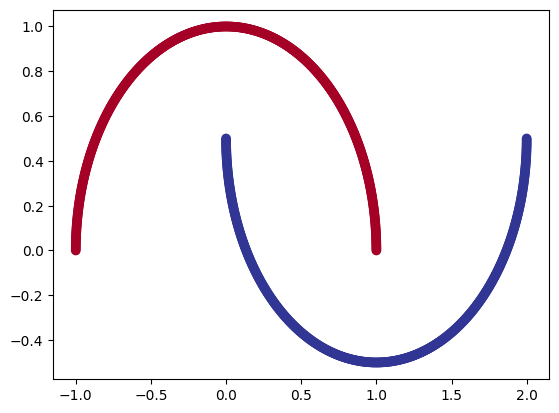

In [389]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

In [390]:
import torch
from torch import nn

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.0087,  0.3682],
         [ 0.9214, -0.4969],
         [ 0.9402, -0.4982],
         [ 0.4659, -0.3454],
         [-0.8504,  0.5261]]),
 tensor([1., 1., 1., 1., 0.]))

In [391]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [392]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [393]:
class ModelClassification(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_1 = ModelClassification().to(device)

model_1

ModelClassification(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [394]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [395]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [396]:
torch.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_true=y_train,y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    # Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    # Calculate loss and accuracy
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

  if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69536, Accuracy: 37.25% | Test Loss: 0.69462, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.38584, Accuracy: 81.62% | Test Loss: 0.40274, Test Accuracy: 76.50%
Epoch: 200 | Loss: 0.23521, Accuracy: 88.75% | Test Loss: 0.23915, Test Accuracy: 91.00%
Epoch: 300 | Loss: 0.18844, Accuracy: 91.62% | Test Loss: 0.18707, Test Accuracy: 92.50%
Epoch: 400 | Loss: 0.14797, Accuracy: 93.88% | Test Loss: 0.14573, Test Accuracy: 94.00%
Epoch: 500 | Loss: 0.10225, Accuracy: 96.12% | Test Loss: 0.09955, Test Accuracy: 97.50%
Epoch: 600 | Loss: 0.06423, Accuracy: 98.75% | Test Loss: 0.06165, Test Accuracy: 98.50%
Epoch: 700 | Loss: 0.04051, Accuracy: 100.00% | Test Loss: 0.03834, Test Accuracy: 100.00%
Epoch: 800 | Loss: 0.02720, Accuracy: 100.00% | Test Loss: 0.02539, Test Accuracy: 100.00%
Epoch: 900 | Loss: 0.01952, Accuracy: 100.00% | Test Loss: 0.01800, Test Accuracy: 100.00%


In [397]:
model_1.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_1(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

In [398]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


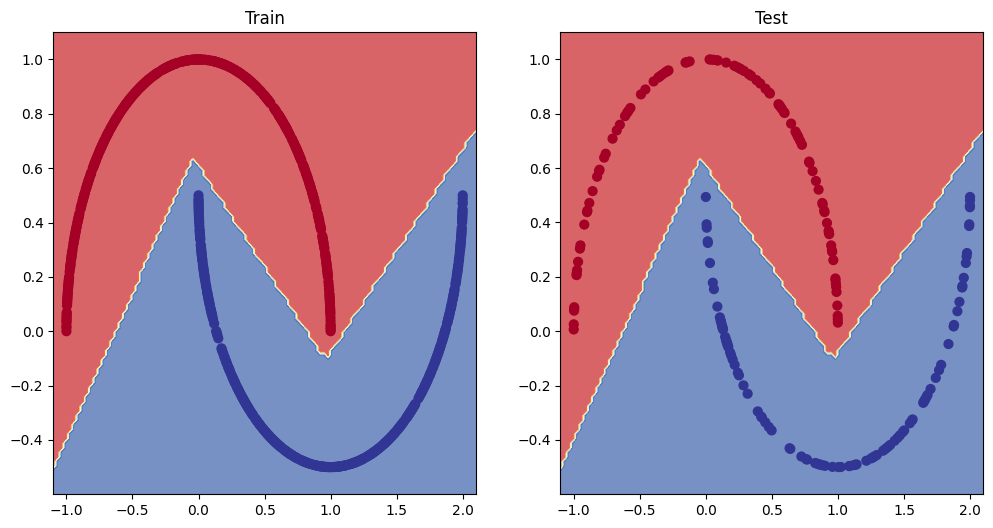

In [399]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test) # model_3 = has non-linearity

## Tanh function

In [400]:
import numpy as np

def tanh(z):
	return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))

# Data generation with spirals function

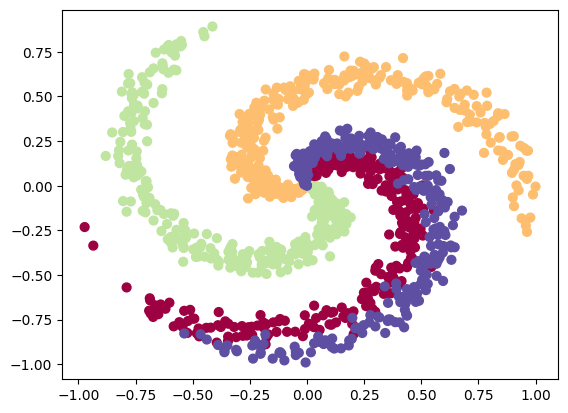

In [401]:
N = 300 # number of points per class
D = 2 # dimensionality
K = 4 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [402]:
X_spiral = torch.from_numpy(X).type(torch.float)
y_spiral = torch.from_numpy(y).type(torch.LongTensor)

In [403]:
RANDOM_SEED = 42

X_spiral_train, X_spiral_test, y_spiral_train, y_spiral_test = train_test_split(X_spiral,
    y_spiral,
    test_size=0.2,
    random_state=RANDOM_SEED
)
len(X_spiral_train), len(X_spiral_test), len(y_spiral_train), len(X_spiral_test)

(960, 240, 960, 240)

In [404]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [405]:
class SpiralModel(nn.Module):
  def __init__(self,input_features,output_features,hiden_units=8):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=input_features, out_features=hiden_units)
    self.layer_2 = nn.Linear(in_features=hiden_units, out_features=hiden_units)
    self.layer_3 = nn.Linear(in_features=hiden_units, out_features=output_features)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_2 = SpiralModel(
    input_features=D,
    output_features=K,
    hiden_units=16,
).to(device)

model_2

SpiralModel(
  (layer_1): Linear(in_features=2, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=16, bias=True)
  (layer_3): Linear(in_features=16, out_features=4, bias=True)
  (relu): ReLU()
)

In [406]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(),
                            lr=0.02)

In [407]:
torch.manual_seed(42)

epochs = 1000

X_spiral_train, y_spiral_train = X_spiral_train.to(device), y_spiral_train.to(device)
X_spiral_test, y_spiral_test = X_spiral_test.to(device), y_spiral_test.to(device)

for epoch in range(epochs):
  y_logits = model_2(X_spiral_train)
  y_pred = torch.softmax(y_logits,dim=1).argmax(dim=1)

  loss = loss_fn(y_logits,y_spiral_train)
  acc = accuracy_fn(y_true=y_spiral_train,
                    y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_2.eval()
  with torch.inference_mode():
    test_logits = model_2(X_spiral_test).squeeze()
    test_pred = torch.softmax(test_logits,dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits,y_spiral_test)
    test_acc = accuracy_fn(y_true=y_spiral_test,
                    y_pred=test_pred)

  if epoch % 100 == 0:
    print(f'Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%')

Epoch: 0 | Loss: 1.41099 | Acc: 25.00% | Test Loss: 1.38678 | Test Acc: 25.00%
Epoch: 100 | Loss: 0.19644 | Acc: 93.44% | Test Loss: 0.18659 | Test Acc: 93.33%
Epoch: 200 | Loss: 0.12321 | Acc: 96.04% | Test Loss: 0.10116 | Test Acc: 96.25%
Epoch: 300 | Loss: 0.10977 | Acc: 96.46% | Test Loss: 0.09194 | Test Acc: 96.67%
Epoch: 400 | Loss: 0.10382 | Acc: 96.77% | Test Loss: 0.09421 | Test Acc: 96.67%
Epoch: 500 | Loss: 0.10092 | Acc: 96.25% | Test Loss: 0.08775 | Test Acc: 96.67%
Epoch: 600 | Loss: 0.09730 | Acc: 96.56% | Test Loss: 0.08834 | Test Acc: 96.67%
Epoch: 700 | Loss: 0.09442 | Acc: 96.67% | Test Loss: 0.09144 | Test Acc: 96.67%
Epoch: 800 | Loss: 0.09455 | Acc: 96.56% | Test Loss: 0.09244 | Test Acc: 96.67%
Epoch: 900 | Loss: 0.09285 | Acc: 96.77% | Test Loss: 0.09451 | Test Acc: 96.67%


In [408]:
model_2.eval()
with torch.inference_mode():
    y_logits = model_2(X_spiral_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  13.2559,  -29.9434,  -26.2696,   17.6011],
        [ -21.3855,    1.5245,   34.1890, -116.0434],
        [  -3.4659,  -20.6366,  -25.5517,   -0.3518],
        [ -11.4128,   -1.1630,  -41.1043,  -29.2061],
        [   6.5224,  -26.6015,   -7.5114,   -6.4012],
        [   4.0402,  -26.1078,  -24.3106,    9.1042],
        [ -22.9330,   10.8311,  -12.4398,   -3.2316],
        [  -2.5598,  -13.1338,  -32.8820,    1.0301],
        [ -12.9106,    1.0598,  -12.7499,  -35.9549],
        [  -5.9217,  -13.4945,   40.4043, -104.8193]], device='cuda:0')

In [409]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_spiral_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_spiral_test, y_pred=y_preds)}%")

Predictions: tensor([3, 2, 3, 1, 0, 3, 1, 3, 1, 2], device='cuda:0')
Labels: tensor([3, 2, 0, 1, 0, 3, 1, 3, 1, 2], device='cuda:0')
Test accuracy: 95.83333333333334%


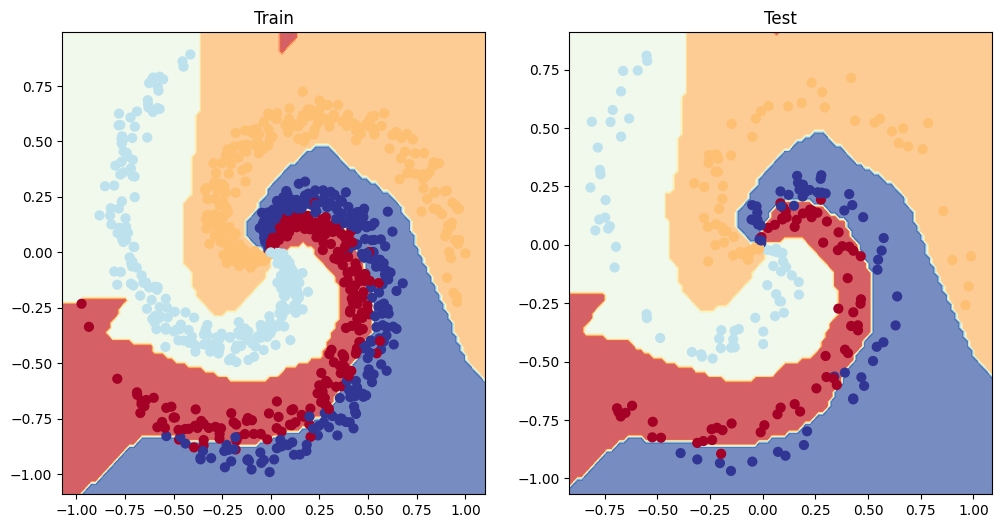

In [410]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_2, X_spiral_train, y_spiral_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_spiral_test, y_spiral_test)